In [1]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.spaces import MultiDiscrete, Discrete
import matplotlib.pyplot as plt 


In [2]:
print(gym.__version__)

0.28.1


# Creating a Custom Environment



In [3]:
# make an environment
import random
import numpy as np
class SchedulerEnvironment(gym.Env):
    def __init__(self, scenario_one = True,
                 terminate_num = 200,
                 mean_delay_one = 6,
                 mean_delay_two = 4,
                 margin_of_delay = 1,
                 packet_arrival_one = 0.3,
                 packet_arrival_two = 0.25,
                 packet_arrival_best_effort = 0.4,
                 max_queue_size = 10,
                 max_delay = 100
                ):
        self.scenario_one = scenario_one
        self.mean_delay_one = mean_delay_one
        self.mean_delay_two = mean_delay_two
        self.margin_of_delay = margin_of_delay


        self.queue_one_incoming_packet = 0.0
        self.queue_two_incoming_packet = 0.0
        self.queue_best_effort_incoming_packet = 0.0 

        self.packet_arrival_one = packet_arrival_one
        self.packet_arrival_two = packet_arrival_two
        self.packet_arrival_best_effort = packet_arrival_best_effort

        self.incoming_packets = dict(
            {
                0: self.queue_one_incoming_packet,
                1: self.queue_two_incoming_packet,
                2: self.queue_best_effort_incoming_packet

            }
            )


        self.step_counter = 0 # i.e. timeslots
        self.terminate_num = terminate_num

        # maximum size of the queue
        self.max_queue_size = max_queue_size
        
        # can adjust size of max delay in timeslots after initial observations
        self.max_delay = max_delay

#         observation space is the average of the mean delays. 
        self.observation_space = spaces.Dict({
            "queues": spaces.Box(low = 0, high = self.max_delay, shape = (3,self.max_queue_size), dtype=int),
            "avg_delays": spaces.Box(low = 0, high = self.max_delay, shape = (1,3), dtype = int)
        })

        self.queue_one_delay = [] 

        self.queue_two_delay = []

        self.queue_best_effort_delay = [] 

        self.queue_delays = dict(
            {
                0: self.queue_one_delay,
                1: self.queue_two_delay,
                2: self.queue_best_effort_delay
            }
        )

        self.queue_one_removed = 0
        self.queue_two_removed = 0
        self.queue_best_effort_removed = 0

        self.removed_packets = dict(
            {
                0: self.queue_one_removed,
                1: self.queue_two_removed,
                2: self.queue_best_effort_removed
            }
        )

        self.current_state = None
        
        self.action_space = spaces.Discrete(3)
        
        self._action_to_queue = {
                0: self.queue_delays[0],
                1: self.queue_delays[1],
                2: self.queue_delays[2]
            }

    def _increment_delay(self):
        for i in range(len(self.queue_delays)):    
            for j in range(len(self.queue_delays[i])):
                if (self.queue_delays[i][j] < self.max_delay):
                    self.queue_delays[i][j] += 1

    def _can_add_packets(self, packet_arrival, action ):
        # increment before evaluating arrival. 
        self.incoming_packets[action] += packet_arrival
        packet_arrived = self.incoming_packets[action] >= 1.0
        not_max_size = len(self.queue_delays[action]) < self.max_queue_size

        if packet_arrived and not_max_size:
            self.incoming_packets[action] -= 1.0
            self.queue_delays[action].append(0)                     

    def _add_packets(self):           
        self._can_add_packets(self.packet_arrival_one, 0)
        self._can_add_packets(self.packet_arrival_two, 1)
        self._can_add_packets(self.packet_arrival_best_effort, 2)

        return
     
    def _modify_states(self):
        # will not calculate delay for freshly added packets. 
        self._increment_delay()
        self._add_packets()
        return 
    
    def _get_obs(self):
        
        avg_one = self._calculate_avg_delay(self.queue_delays[0])
        avg_two = self._calculate_avg_delay(self.queue_delays[1])
        avg_best = self._calculate_avg_delay(self.queue_delays[2])

        # return average delays for each queue. 
        avg_mean_all_queues = [avg_one, avg_two, avg_best]
        
        return { 
            "queues": self.queue_delays,
            "avg_delays": avg_mean_all_queues
            }
    
    def _calculate_avg_delay(self, queue):
        queue_size = len(queue)
        if (queue_size == 0):
            return 0
        
        # sum
        sum = 0
        for i in range(queue_size):
            sum += queue[i]
        
        # avg
        avg = sum / queue_size
        return avg

    def _get_info(self):

        # return the number of packets removed in each queue. 
        
        packets_removed = [self.removed_packets[0], self.removed_packets[1], self.removed_packets[2]]

        # return the queue num.
        return [packets_removed, self.step_counter + 1]
 
    def _initialise_delays(self, queue):
        # give a random delay between 0 and 5
        size_of_queue = len(queue)
        for i in range(size_of_queue):
            queue[i] = random.randint(0, 5)

    def _set_all_zero(self):
        for i in range((3)):
            self.queue_delays[i].clear()
            self.removed_packets[i] = 0
            self.incoming_packets[i] = 0.0

        self.step_counter = 0
        self.current_state = None
        
    
    def reset(self, seed=None):
        # reset everything 
        self._set_all_zero()

        # set the size of the queue. 
        self.queue_delays[0] = self.observation_space["queues"].sample().tolist()
        self.queue_delays[1] = self.observation_space["queues"].sample().tolist()
        self.queue_delays[2] = self.observation_space["queues"].sample().tolist()

        # set seed before randomising 
        random.seed(seed)

        self._initialise_delays(self.queue_delays[0])
        self._initialise_delays(self.queue_delays[1])
        self._initialise_delays(self.queue_delays[2])

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info
    
    def _reward_function(self, action):       
        reward = 0

        mean_delays = dict(
            {
                0: self.mean_delay_one,
                1: self.mean_delay_two
            }
        )

        if (action == 2):
        
            # reward taking the best effort queue when mean delays are adjusted
            # for priority queues.
            avg_first_queue = self._calculate_avg_delay(self.queue_delays[0])
            within_margin_first_queue = ( avg_first_queue <= mean_delays[0] + self.margin_of_delay)
            
            avg_second_queue = self._calculate_avg_delay(self.queue_delays[1])
            within_margin_second_queue = ( avg_second_queue <= mean_delays[1] + self.margin_of_delay)
            
            if (within_margin_first_queue and within_margin_second_queue):
                reward = 1

            # Punish for not prioritising. 
            else:
                reward = -1

        else:
            avg_delay = self._calculate_avg_delay(self.queue_delays[0])
            # packet delay > mean delay by the margin
            if (mean_delays[action] + self.margin_of_delay < avg_delay):
                # encourage minimising the delay for this queue.
                reward = 0

            # packet delay < mean delay by the margin
            elif (mean_delays[action] - self.margin_of_delay > avg_delay):
                # discourage minimising the delay too much.
                reward = -1

            # packet delay within margin, don't perform again. 
            else:
                reward = -1

        return reward 

    def _remove_packet(self, action):
        # retrieve the packet. 
        self.queue_delays[action].pop(0)
        self.removed_packets[action] += 1

    def step(self, action):
        reward = 0

        if len(self.queue_delays[action]) == 0:
            reward = -1

        else:
            reward = self._reward_function(action)

            if self.scenario_one:
                self._remove_packet(action)
    
            else: 
                if (action == self.current_state):
                    self._remove_packet(action)

        # perform queue switch given the conditions.
        if not self.scenario_one:

            if (action != self.current_state):
                self.current_state = action

                # should consider if switching is the correct approach
                # long term. Switching twice in a row is a waste of time.
                reward -= 1
                
        self._modify_states()

        info = self._get_info()

        terminated = False
        if self.step_counter + 1 == self.terminate_num:
            terminated = True
        self.step_counter += 1

        # observation made after modifying states. 
        observation = self._get_obs()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

In [4]:
env = SchedulerEnvironment(terminate_num = 50) 

In [5]:
print('State space Low: ', env.observation_space["queues"].low)
print('State space High: ', env.observation_space["queues"].high)

State space Low:  [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
State space High:  [[100 100 100 100 100 100 100 100 100 100]
 [100 100 100 100 100 100 100 100 100 100]
 [100 100 100 100 100 100 100 100 100 100]]


In [6]:
print('State space Low: ', env.observation_space["avg_delays"].low)
print('State space High: ', env.observation_space["avg_delays"].high)

State space Low:  [[0 0 0]]
State space High:  [[100 100 100]]


In [7]:
def print_info(info):
    print("----------")
    print("current step =", info[1])
    print("-----")
    print("Packets removed from first queue:", info[0][0])
    print("Packets removed from second queue:", info[0][1])
    print("Packets removed from best-effort queue:", info[0][2])
    

In [8]:
def print_observation(observation):
    print("----------")
    print("First queue:", observation["queues"][0])
    print("Second queue:", observation["queues"][1])
    print("Best effort queue:", observation["queues"][2])
    print("-----")
    print("Average delay of first queue: {:.2f}".format(observation["avg_delays"][0]))
    print("Average delay of second queue: {:.2f}".format(observation["avg_delays"][1]))
    print("Average delay of best-effort queue: {:.2f}".format(observation["avg_delays"][2]))

In [9]:
env.action_space.sample()

1

In [10]:
obs, info = env.reset()
print_observation(obs)
print_info(info)

----------
First queue: [5, 4, 3]
Second queue: [4, 5, 2]
Best effort queue: [4, 5, 5]
-----
Average delay of first queue: 4.00
Average delay of second queue: 3.67
Average delay of best-effort queue: 4.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 0


In [11]:
def random_scheduler(seed = None):
    terminated = False 
    truncated = False

    # reset seeds the randomiser
    env.reset(seed)
    score = 0

    while not terminated:  
    #     random 
        action = random.randint(0, 2)
        obs, reward, terminated, truncated, info = env.step(action)
        score += reward
        print_observation(obs)
        print_info(info)
    print(score)

In [12]:
random_scheduler(0)

----------
First queue: [4, 4, 1]
Second queue: [5, 4]
Best effort queue: [4, 3, 4]
-----
Average delay of first queue: 3.00
Average delay of second queue: 4.50
Average delay of best-effort queue: 3.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [5, 5, 2]
Second queue: [6, 5]
Best effort queue: [4, 5]
-----
Average delay of first queue: 4.00
Average delay of second queue: 5.50
Average delay of best-effort queue: 4.50
----------
current step = 2
-----
Packets removed from first queue: 0
Packets removed from second queue: 1
Packets removed from best-effort queue: 1
----------
First queue: [6, 3]
Second queue: [7, 6]
Best effort queue: [5, 6, 0]
-----
Average delay of first queue: 4.50
Average delay of second queue: 6.50
Average delay of best-effort queue: 3.67
----------
current step = 3
-----
Packets removed from first queue: 1
Packets removed from second queu

In [13]:
random_scheduler(1)

----------
First queue: [2, 5, 1]
Second queue: [1, 4]
Best effort queue: [4, 4, 6]
-----
Average delay of first queue: 2.67
Average delay of second queue: 2.50
Average delay of best-effort queue: 4.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [6, 2]
Second queue: [2, 5]
Best effort queue: [5, 5, 7]
-----
Average delay of first queue: 4.00
Average delay of second queue: 3.50
Average delay of best-effort queue: 5.67
----------
current step = 2
-----
Packets removed from first queue: 1
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [3]
Second queue: [3, 6]
Best effort queue: [6, 6, 8, 0]
-----
Average delay of first queue: 3.00
Average delay of second queue: 4.50
Average delay of best-effort queue: 5.00
----------
current step = 3
-----
Packets removed from first queue: 2
Packets removed from second queu

In [14]:
random_scheduler(2)

----------
First queue: [1, 1, 1]
Second queue: [3, 2, 6]
Best effort queue: [3, 3]
-----
Average delay of first queue: 1.00
Average delay of second queue: 3.67
Average delay of best-effort queue: 3.00
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 1
----------
First queue: [2, 2]
Second queue: [4, 3, 7]
Best effort queue: [4, 4]
-----
Average delay of first queue: 2.00
Average delay of second queue: 4.67
Average delay of best-effort queue: 4.00
----------
current step = 2
-----
Packets removed from first queue: 1
Packets removed from second queue: 0
Packets removed from best-effort queue: 1
----------
First queue: [3, 3]
Second queue: [5, 4, 8]
Best effort queue: [5, 0]
-----
Average delay of first queue: 3.00
Average delay of second queue: 5.67
Average delay of best-effort queue: 2.50
----------
current step = 3
-----
Packets removed from first queue: 1
Packets removed from second queu

In [15]:
def random_scheduler_plot(env, seed = None):   
    terminated = False 
    truncated = False
    obs, info = env.reset(seed)

#     mean delay of queues: observation["avg_delays"][queue_observed]
    y0 = []
    y1 = []
    y2 = []

#     step counter: info[1]
    x = []

    while not terminated:  
    #     edf 
        action = random.randint(0, 2)
        obs, reward, terminated, truncated, info = env.step(action)

        y0.append(obs["avg_delays"][0])
        y1.append(obs["avg_delays"][1])
        y2.append(obs["avg_delays"][2])

        x.append(info[1])

    plt.plot(x, y0)
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.legend(["queue1", "queue2", "best-effort"])

    plt.xlabel('Step counter')
    plt.ylabel('mean delay of queue') 
    plt.show()

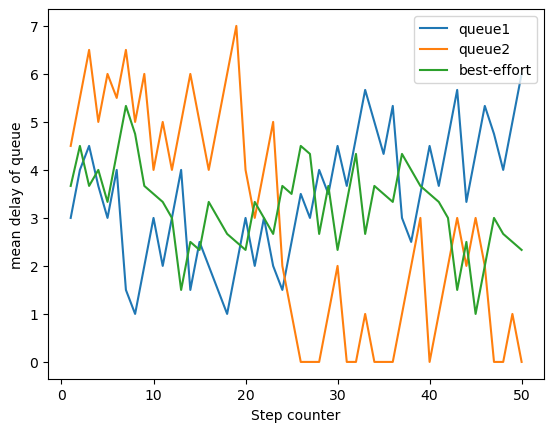

In [16]:
random_scheduler_plot(env, 0)

In [17]:
def random_scheduler_hist(env, seed = None):
    terminated = False 
    truncated = False
    
#     mean delay of queues: observation["avg_delays"][queue_observed]
    x0 = []
    x1 = []
    x2 = []
    
    # reset seeds the randomiser
    env.reset(seed)
    
#     rand int needs its own seed. 
    random.seed(seed)

    while not terminated:  
    #     random 
        action = random.randint(0, 2)
        obs, reward, terminated, truncated, info = env.step(action)
        
        x0.append(len(obs["queues"][0]))
        x1.append(len(obs["queues"][1]))
        x2.append(len(obs["queues"][2]))

    plt.hist(x0)
    plt.hist(x1)
    plt.hist(x2)
    plt.legend(["queue1", "queue2", "best-effort"])

    plt.xlabel('Lengths')
    plt.ylabel('Frequency') 
    plt.show()

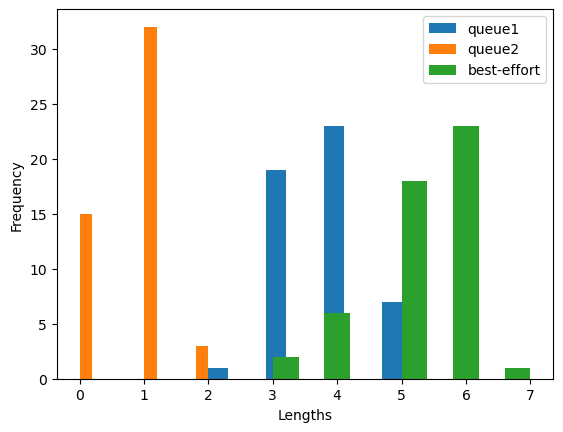

In [18]:
random_scheduler_hist(env, 0)

In [19]:
class EDFSchedulerWrapper(SchedulerEnvironment):  
    
    def __init__(self, scenario_one = True, terminate_num = 200, mean_delay_one = 6, mean_delay_two = 4, margin_of_delay = 1):
        super().__init__(scenario_one = scenario_one,
                       terminate_num = terminate_num,
                       mean_delay_one = mean_delay_one,
                       mean_delay_two = mean_delay_two,
                       margin_of_delay = margin_of_delay)
        
        self.current_packet_removed_one = 0
        self.current_packet_removed_two = 0
        self.current_packet_removed_best = 0
        
#         random intialisation values picked with the same mean delays. 
        self.deadline_one = 6
        self.deadline_two = 4
        self.deadline_best_effort = 10
        
        self.deadlines = np.array([self.deadline_one, self.deadline_two, self.deadline_best_effort])

    def reset(self, seed=None):
        self.deadlines = np.array([self.deadline_one, self.deadline_two, self.deadline_best_effort])
        return super().reset(seed)
        
    def _edf_action(self, queue_deadline):
        
#         predefine needed for EDF scheduler. 
        mean_delay_best_effort = 10
        
        expected_mean_delays = [self.mean_delay_one, self.mean_delay_two, mean_delay_best_effort]
        
        obs = self._get_obs()
        info = self._get_info()
        
#         random increment values. 
        mean_delay_one_increment = 6
        mean_delay_two_increment = 4
        mean_delay_best_effort_increment = 10
        
        increments = [mean_delay_one_increment, mean_delay_two_increment, mean_delay_best_effort_increment]
    
#         increment deadlines given the conditions: mean delay < expected delay.  
        if (obs["avg_delays"][queue_deadline] < expected_mean_delays[queue_deadline]):
        
#         increment by the amount which the mean delay was off from the expected delay.
            self.deadlines[queue_deadline] += increments[queue_deadline] 
            
#         constant that modifies the level which the difference between mean delays is increased.
#         perform multiplication as the expected mean values are small for queue 1 and 2. 
            FACTOR_DEADLINE = 7
            increment_deadline = (expected_mean_delays[queue_deadline] - obs["avg_delays"][queue_deadline]) * FACTOR_DEADLINE
            self.deadlines[queue_deadline] += increment_deadline
            
        else:
#             increment normally.
            self.deadlines[queue_deadline] += increments[queue_deadline]
            
#     choose the smallest deadline to return as the action. 
        return np.argmin(self.deadlines, axis = 0)
    
#     mean_delay_one += mean_delay_one_increment
    def perform_scheduling(self, seed = None):
        terminated = False 
        truncated = False
        
        obs, info = self.reset(seed)
        
#         #  0th step 
#         print_observation(obs)
#         print_info(info)
        
#         print("Deadlines:", self.deadlines)
        score = 0
        action = np.argmin(self.deadlines, axis = 0)
        while not terminated: 

        #     edf
            obs, reward, terminated, truncated, info = self.step(action)
            action = self._edf_action(action)
            score += reward
            print_observation(obs)
            print_info(info)
        print(score)
        
    
    def edf_scheduler_hist(self, seed = None):        
        terminated = False 
        truncated = False
        obs, info = self.reset(seed)

    #     mean delay of queues: observation["avg_delays"][queue_observed]
        x0 = []
        x1 = []
        x2 = []
        
        action = np.argmin(self.deadlines, axis = 0)
        while not terminated:  
        #     edf 
            obs, reward, terminated, truncated, info = self.step(action)
            action = self._edf_action(action)
        
            x0.append(len(obs["queues"][0]))
            x1.append(len(obs["queues"][1]))
            x2.append(len(obs["queues"][2]))
            

        plt.hist(x0)
        plt.hist(x1)
        plt.hist(x2)
        plt.legend(["queue1", "queue2", "best-effort"])
        
        plt.xlabel('Lengths')
        plt.ylabel('Frequency') 
        plt.show()
        
    def edf_scheduler_plot(self, seed = None):
        terminated = False 
        truncated = False
        obs, info = self.reset(seed)

    #     mean delay of queues: observation["avg_delays"][queue_observed]
        y0 = []
        y1 = []
        y2 = []

    #     step counter: info[1]
        x = []
        
        #  0th step 
        print_observation(obs)
        print_info(info)
        
        print("Deadlines:", self.deadlines)

        action = np.argmin(self.deadlines, axis = 0)
        while not terminated:  
        #     edf 
            obs, reward, terminated, truncated, info = self.step(action)
            action = self._edf_action(action)
            
            y0.append(obs["avg_delays"][0])
            y1.append(obs["avg_delays"][1])
            y2.append(obs["avg_delays"][2])
            
            x.append(info[1])

        plt.plot(x, y0)
        plt.plot(x, y1)
        plt.plot(x, y2)
        plt.legend(["queue1", "queue2", "best-effort"])
        
        plt.xlabel('Step counter')
        plt.ylabel('mean delay of queue') 
        plt.show()

In [20]:
# predefine the expected mean delay for first queue, second queue and best effort queue. 
mean_delay_one = 6
mean_delay_two = 4
mean_delay_best_effort = 10

edf_env = EDFSchedulerWrapper(terminate_num = 50, mean_delay_one = mean_delay_one, mean_delay_two = mean_delay_two)


In [21]:
edf_env.perform_scheduling(0)

----------
First queue: [4, 4, 1]
Second queue: [5, 4]
Best effort queue: [4, 3, 4]
-----
Average delay of first queue: 3.00
Average delay of second queue: 4.50
Average delay of best-effort queue: 3.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [5, 2]
Second queue: [6, 5]
Best effort queue: [5, 4, 5]
-----
Average delay of first queue: 3.50
Average delay of second queue: 5.50
Average delay of best-effort queue: 4.67
----------
current step = 2
-----
Packets removed from first queue: 1
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [6, 3]
Second queue: [6]
Best effort queue: [6, 5, 6, 0]
-----
Average delay of first queue: 4.50
Average delay of second queue: 6.00
Average delay of best-effort queue: 4.25
----------
current step = 3
-----
Packets removed from first queue: 1
Packets removed from second queu

----------
First queue: [3, 3, 0]
Second queue: [2, 4, 3]
Best effort queue: [3, 2, 3]
-----
Average delay of first queue: 2.00
Average delay of second queue: 3.00
Average delay of best-effort queue: 2.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 0
Deadlines: [ 6  4 10]


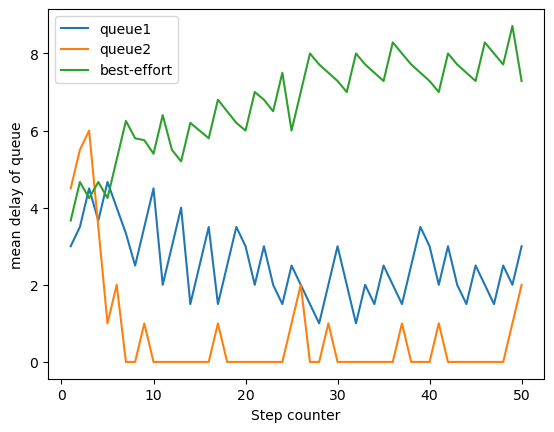

In [22]:
edf_env.edf_scheduler_plot(0)

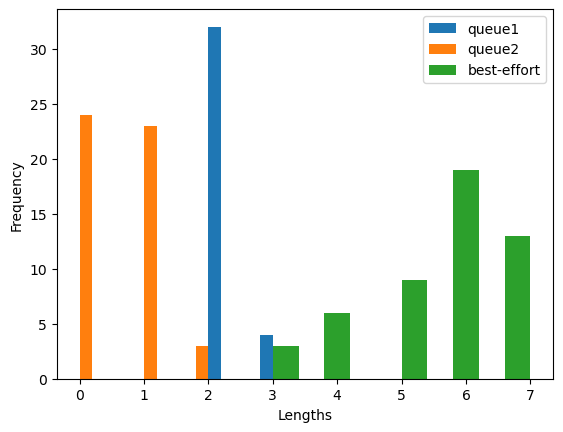

In [23]:
edf_env.edf_scheduler_hist(0)

We can see that the EDF is already performing much better than the random queue. 

We infer that the EDF scheduler attempts to keep the second queue very small, which is inefficient. 

In [24]:
class PrioritySchedulerWrapper(SchedulerEnvironment):
    def __init__(self, scenario_one = True, terminate_num = 200, mean_delay_one = 6, mean_delay_two = 4, margin_of_delay = 1):
        super().__init__(scenario_one = scenario_one,
                       terminate_num = terminate_num,
                       mean_delay_one = mean_delay_one,
                       mean_delay_two = mean_delay_two,
                       margin_of_delay = margin_of_delay)
    
    def prioritise_action(self):
#         select the queue based on what reward can be gained.
        action = 0
        mean_delays = dict(
            {
                0: self.mean_delay_one,
                1: self.mean_delay_two
            }
        )

        # choose the best action based on the current state. 
        avg_first_queue = self._calculate_avg_delay(self.queue_delays[0])
        within_margin_first_queue = ( avg_first_queue <= mean_delays[0] + self.margin_of_delay)

        avg_second_queue = self._calculate_avg_delay(self.queue_delays[1])
        within_margin_second_queue = ( avg_second_queue <= mean_delays[1] + self.margin_of_delay)

        if (within_margin_first_queue and within_margin_second_queue):
            action = 2

        else:
#             do action = 1 if the first queue is within margin
            if (within_margin_first_queue):
                action = 1
#                 action is otherwise 0.
        return action  

In [25]:
priority_scheduler_env = PrioritySchedulerWrapper(terminate_num = 50, mean_delay_one = mean_delay_one, mean_delay_two = mean_delay_two)

In [26]:
def priority_scheduler(priority_scheduler_env, seed = None):
    terminated = False 
    truncated = False

    # reset seeds the randomiser
    priority_scheduler_env.reset(seed)
    score = 0

    while not terminated:  
        action = priority_scheduler_env.prioritise_action()
        obs, reward, terminated, truncated, info = priority_scheduler_env.step(action)
        score += reward
        print_observation(obs)
        print_info(info)
    print(score)

In [27]:
def priority_scheduler_plot(priority_scheduler_env, seed = None):
    terminated = False 
    truncated = False

    # reset seeds the randomiser
    priority_scheduler_env.reset(seed)
    
    #     mean delay of queues: observation["avg_delays"][queue_observed]
    y0 = []
    y1 = []
    y2 = []

#     step counter: info[1]
    x = []

    while not terminated:  
    #     random 
        action = priority_scheduler_env.prioritise_action()
        obs, reward, terminated, truncated, info = priority_scheduler_env.step(action)
        y0.append(obs["avg_delays"][0])
        y1.append(obs["avg_delays"][1])
        y2.append(obs["avg_delays"][2])
        
        x.append(info[1])
    plt.plot(x, y0)
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.legend(["queue1", "queue2", "best-effort"])
    
    plt.xlabel('Step counter')
    plt.ylabel('mean delay of queue') 
    plt.show()
    

In [28]:
def priority_scheduler_hist(priority_scheduler_env, seed = None):
    terminated = False 
    truncated = False
    
#     mean delay of queues: observation["avg_delays"][queue_observed]
    x0 = []
    x1 = []
    x2 = []
    # reset seeds the randomiser
    priority_scheduler_env.reset(seed)

    while not terminated:  
        action = priority_scheduler_env.prioritise_action()
        obs, reward, terminated, truncated, info = priority_scheduler_env.step(action)
        
        x0.append(len(obs["queues"][0]))
        x1.append(len(obs["queues"][1]))
        x2.append(len(obs["queues"][2]))

    plt.hist(x0)
    plt.hist(x1)
    plt.hist(x2)
    plt.legend(["queue1", "queue2", "best-effort"])
    
    plt.xlabel('Lengths')
    plt.ylabel('Frequency') 
    plt.show()

In [29]:
priority_scheduler(priority_scheduler_env, 0)

----------
First queue: [4, 4, 1]
Second queue: [3, 5, 4]
Best effort queue: [3, 4]
-----
Average delay of first queue: 3.00
Average delay of second queue: 4.00
Average delay of best-effort queue: 3.50
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 1
----------
First queue: [5, 5, 2]
Second queue: [4, 6, 5]
Best effort queue: [5]
-----
Average delay of first queue: 4.00
Average delay of second queue: 5.00
Average delay of best-effort queue: 5.00
----------
current step = 2
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 2
----------
First queue: [6, 6, 3]
Second queue: [5, 7, 6]
Best effort queue: [0]
-----
Average delay of first queue: 5.00
Average delay of second queue: 6.00
Average delay of best-effort queue: 0.00
----------
current step = 3
-----
Packets removed from first queue: 0
Packets removed from second queu

In [30]:
priority_scheduler(priority_scheduler_env, 1)

----------
First queue: [2, 5, 1]
Second queue: [3, 1, 4]
Best effort queue: [4, 6]
-----
Average delay of first queue: 2.67
Average delay of second queue: 2.67
Average delay of best-effort queue: 5.00
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 1
----------
First queue: [3, 6, 2]
Second queue: [4, 2, 5]
Best effort queue: [7]
-----
Average delay of first queue: 3.67
Average delay of second queue: 3.67
Average delay of best-effort queue: 7.00
----------
current step = 2
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 2
----------
First queue: [4, 7, 3]
Second queue: [5, 3, 6]
Best effort queue: [0]
-----
Average delay of first queue: 4.67
Average delay of second queue: 4.67
Average delay of best-effort queue: 0.00
----------
current step = 3
-----
Packets removed from first queue: 0
Packets removed from second queu

In [31]:
priority_scheduler(priority_scheduler_env, 2)

----------
First queue: [1, 1, 1]
Second queue: [3, 2, 6]
Best effort queue: [3, 3]
-----
Average delay of first queue: 1.00
Average delay of second queue: 3.67
Average delay of best-effort queue: 3.00
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 1
----------
First queue: [2, 2, 2]
Second queue: [4, 3, 7]
Best effort queue: [4]
-----
Average delay of first queue: 2.00
Average delay of second queue: 4.67
Average delay of best-effort queue: 4.00
----------
current step = 2
-----
Packets removed from first queue: 0
Packets removed from second queue: 0
Packets removed from best-effort queue: 2
----------
First queue: [3, 3, 3]
Second queue: [5, 4, 8]
Best effort queue: [0]
-----
Average delay of first queue: 3.00
Average delay of second queue: 5.67
Average delay of best-effort queue: 0.00
----------
current step = 3
-----
Packets removed from first queue: 0
Packets removed from second queu

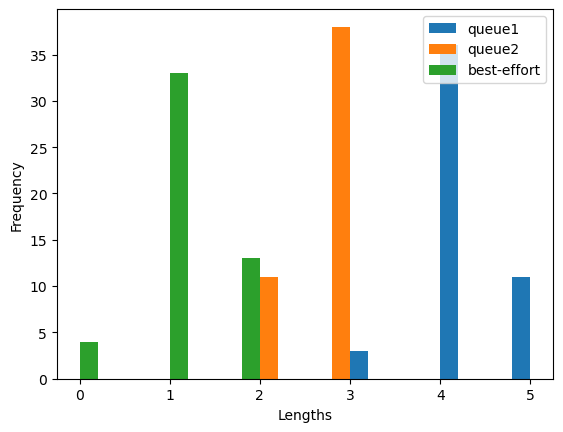

In [32]:
priority_scheduler_hist(priority_scheduler_env, seed = 0)

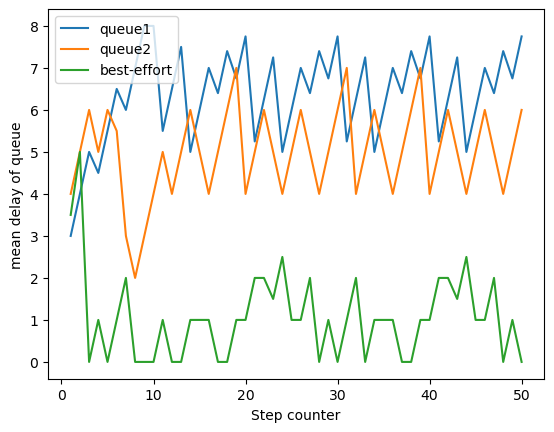

In [33]:
priority_scheduler_plot(priority_scheduler_env, seed = 0)

We can see that the best effort queue can be significantly reduced given the parameters above. 

While the rewards are larger, the best effort queue is being served too often when the expected delays are met for one and two. 
<br>
This outcome would change if priority one and two queues were to have smaller expected delays as below:

In [34]:
expected_mean_delay_one = 2
expected_mean_delay_two = 2
margin_of_delay = 0 
priority_scheduler_env_1 = PrioritySchedulerWrapper(terminate_num = 50,
                                                  mean_delay_one = expected_mean_delay_one,
                                                  mean_delay_two = expected_mean_delay_two,
                                                  margin_of_delay = margin_of_delay)

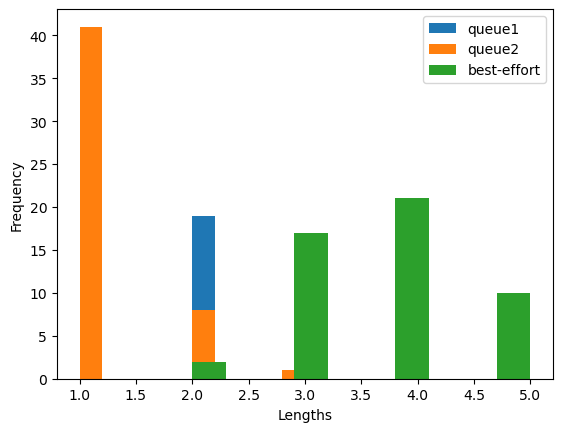

In [35]:
priority_scheduler_hist(priority_scheduler_env_1, seed = 0)

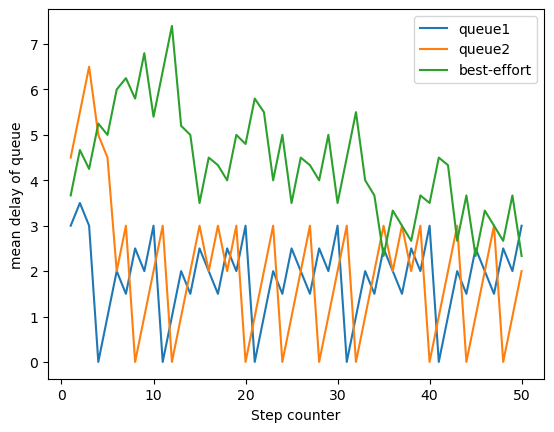

In [36]:
priority_scheduler_plot(priority_scheduler_env_1, seed = 0)

### QLearning Algorithm

In [37]:
def discretize_state(state):

    if isinstance(state, tuple):
        queues = state[0]['avg_delays']
        q1 = state[0]['avg_delays'][0]
        q2 = state[0]['avg_delays'][1]
        q3 = state[0]['avg_delays'][2]
    else:
        queues = state['avg_delays']
        q1 = state['avg_delays'][0]
        q2 = state['avg_delays'][1]
        q3 = state['avg_delays'][2]
        
#     for q in queues:
#         while len(queues[q]) < 10:
#             queues[q].append(0)

    queue_lists = [int(q1), int(q2), int(q3)]  
    arr = np.array(queue_lists)
        
    return arr

In [38]:
def get_state_index(state, max_delay):
#     this determines the state_index
    max_state_per_queue = (max_delay + 1)
    state_index = state[0] * (max_state_per_queue) ** 2 + state[1] * max_state_per_queue + state[2]
    return state_index

In [39]:
def QLearning(env, QTable, learning, discount, epsilon, episodes, max_delay):
    # Env: The OpenAI gym environment
    # Q: Initial Q table
    # learning: Learning Rate of Q learing
    # discount: discount factor (gamma)
    # epsilon: epsilon for exploration vs exploitation
    # episodes: number of episodes to run when learing the Q table
    
    # Initialize variables to hold rewards
    reward_list = []
    ave_reward_list = []
    
    # Epsilon decaying variables
    START_EPSILON_DECAYING = 1
    END_EPSILON_DECAYING = episodes // 2
    epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

    for episode in range(episodes):
        done = False
        total_reward, reward = 0,0
        # get the initial state
        state = env.reset()
        observation, info = env.reset()
        # discretize the state and obtain index of Q-table
        discretState = discretize_state(state)
        state_index = get_state_index(discretState, max_delay)

        steps = 0;
        while done != True:   

            # Determine next action - epsilon greedy strategy for explore vs exploitation
            if np.random.random() < 1 - epsilon:
                # select the best action according to Q-table (exploitation)
                action = np.argmax(QTable[state_index]) % 3

            else:
                # select a random action (exploration)
                action = env.action_space.sample()
                
            # Step and Get the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated 
            discretStateNew = discretize_state(next_state)
                
            # Update the Q table
            QTable[discretState, action] = QTable[discretState, action] + \
                learning * (reward + discount * np.max(QTable[discretStateNew]) - QTable[discretState, action])
        
            # Update variables
            total_reward += reward
            discretState = discretStateNew 
#             state = new_state
            steps = steps + 1
            
        # Update epsilon
        if END_EPSILON_DECAYING >= episode and episode >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value
            
        # Track rewards
        reward_list.append(total_reward)
        
        if (episode + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
#         if ( episode +1) % 100 == 0:    
#             print('Episode {} Average Reward: {}'.format(episode+1, ave_reward))


    env.close()
    
    return QTable, (list(range(100, episodes+1, 100)), ave_reward_list)


Hyper-parameter tuning for Q-Learning

Results completed for Learning rate: 0.4 Discount: 0.7 Epsilon: 0.8
Results completed for Learning rate: 0.4 Discount: 0.8 Epsilon: 0.8
Results completed for Learning rate: 0.5 Discount: 0.7 Epsilon: 0.8
Results completed for Learning rate: 0.5 Discount: 0.8 Epsilon: 0.8
Results completed for Learning rate: 0.6 Discount: 0.7 Epsilon: 0.8
Results completed for Learning rate: 0.6 Discount: 0.8 Epsilon: 0.8


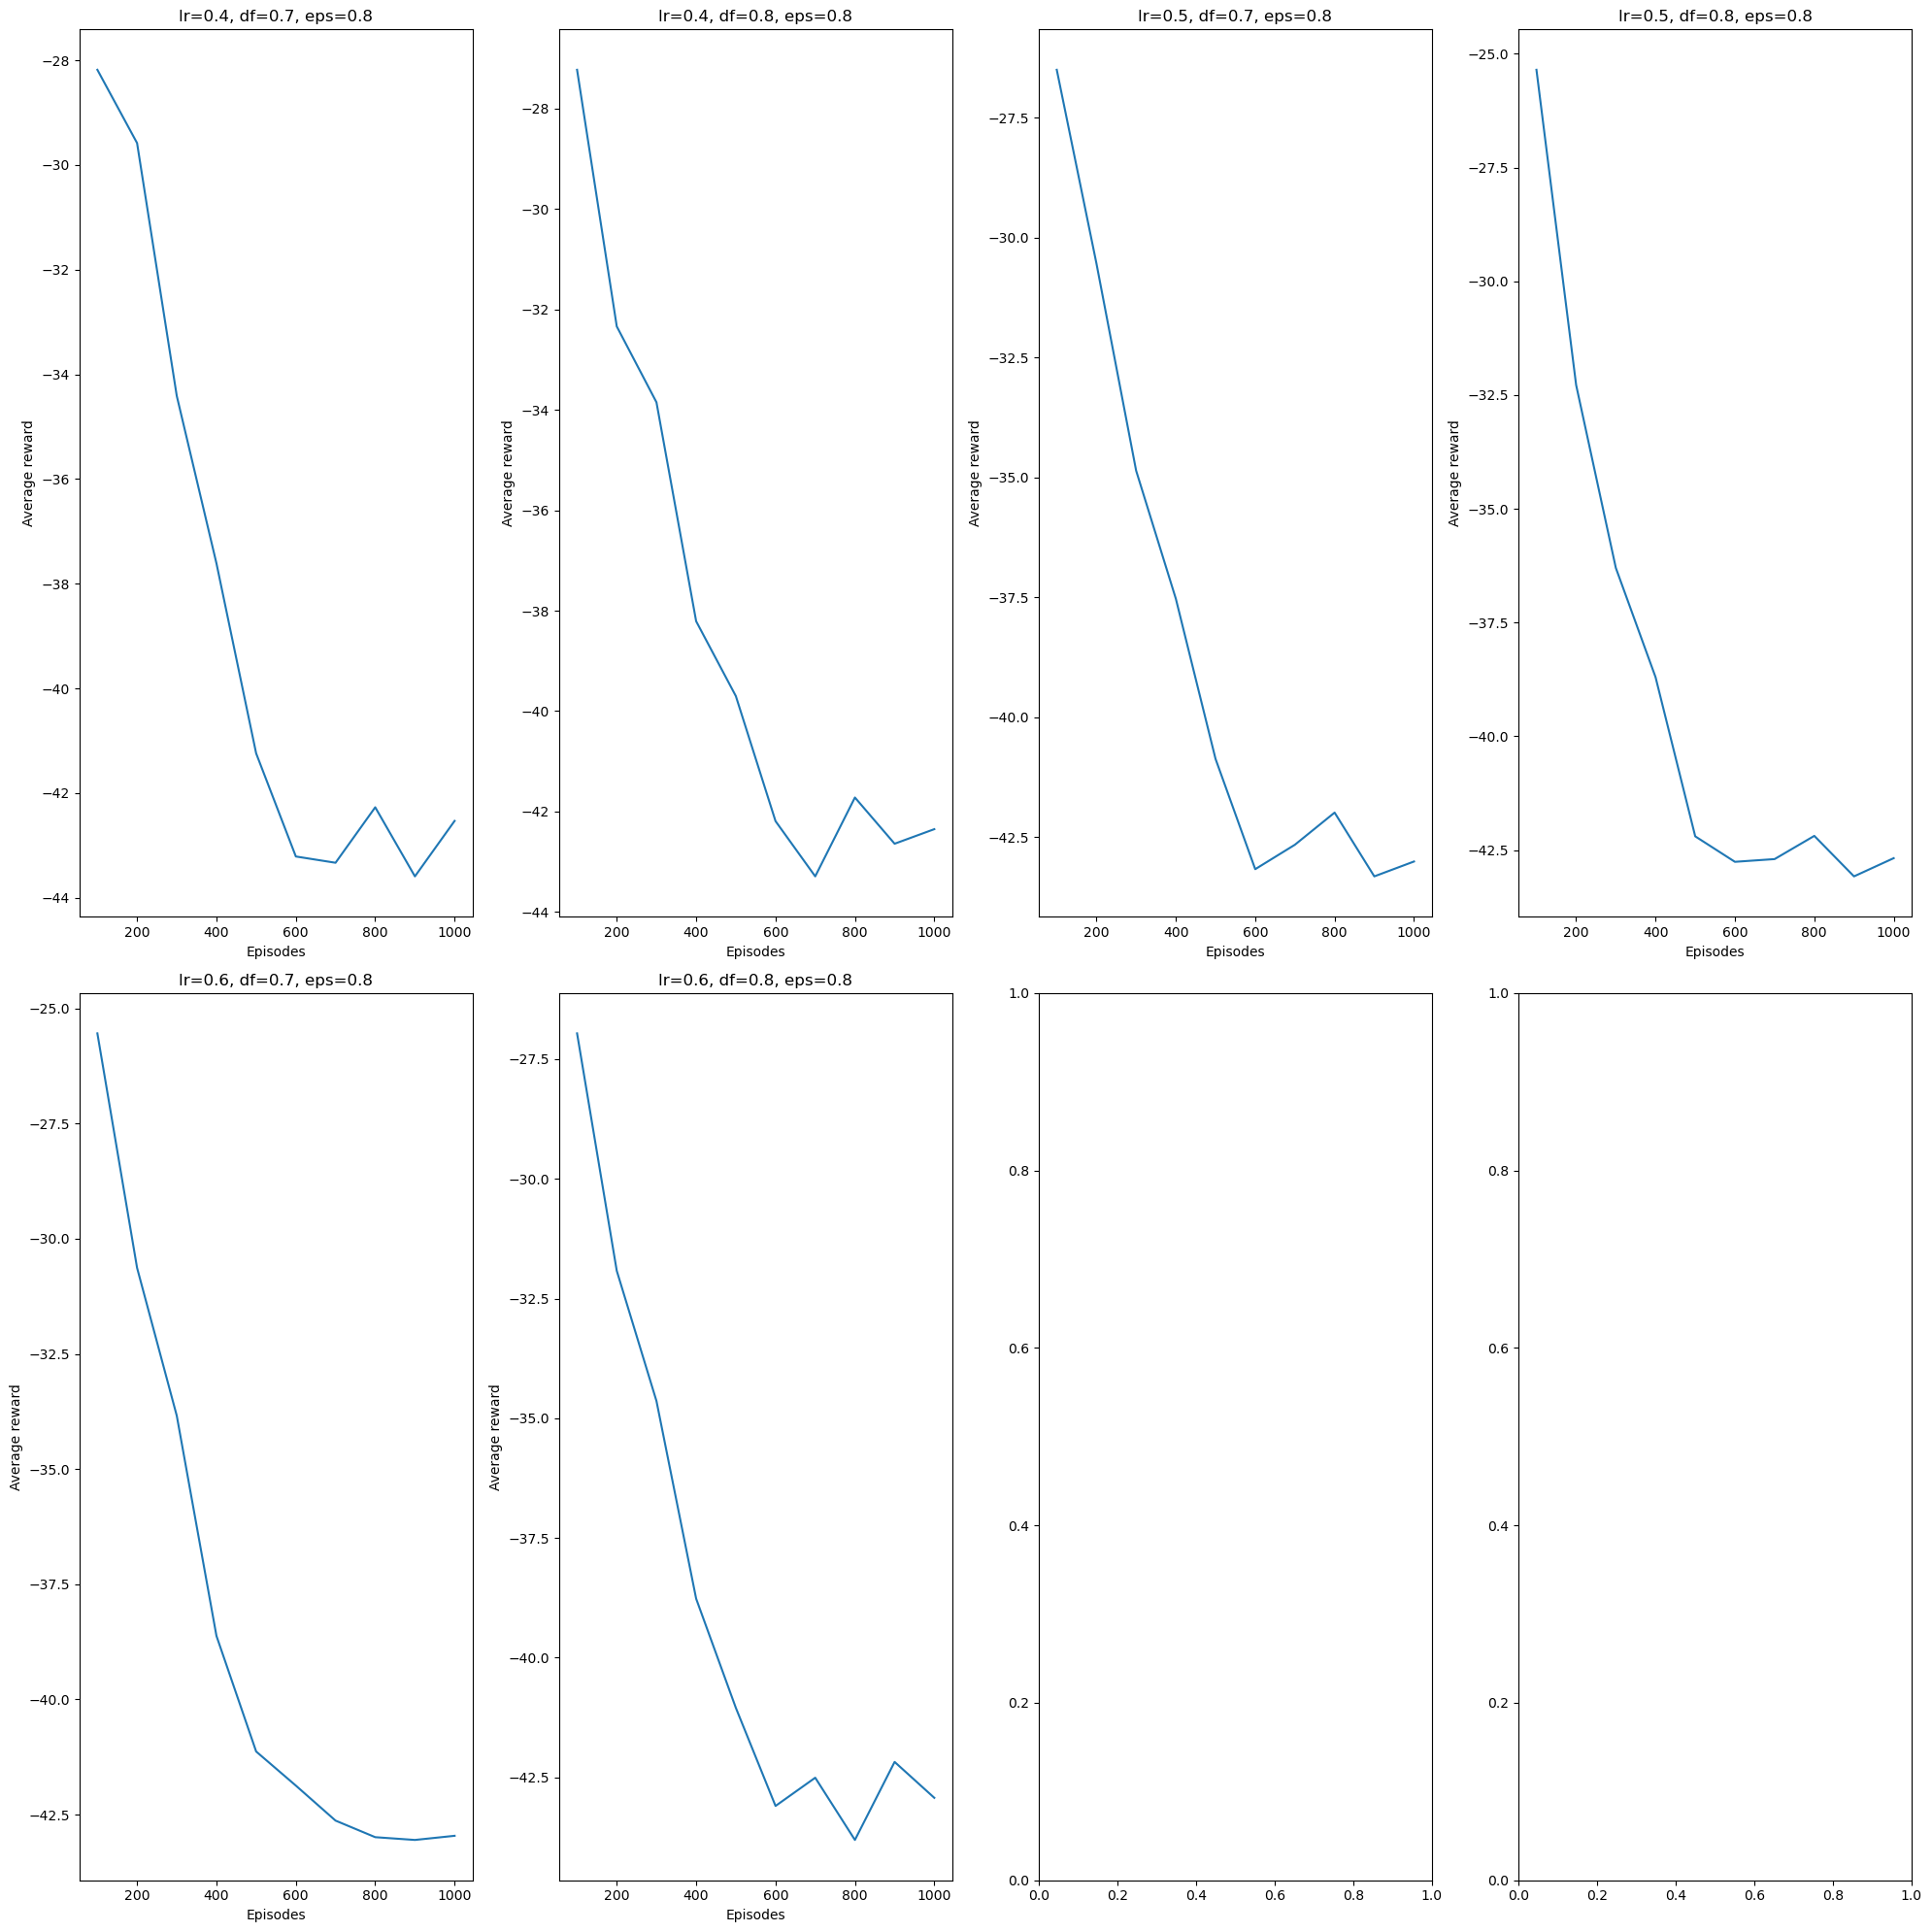

In [41]:
import math
# Run Q-learning algorithm
max_delay = 30
episodes = 1000
num_actions = 3
num_states = (max_delay + 1) ** num_actions

# Initialise a SchedulerEnvironment with max delay
env = SchedulerEnvironment(terminate_num = 50, max_delay = max_delay) 

# Initialise a random Q-Table at dimensions num_states, num_actions
Q = np.random.uniform(low = -1, high = 1, size = (num_states, num_actions))

# Define the possible values for hyper-parameters
learning_rates = [0.4, 0.5, 0.6] 
discount_factors = [0.7, 0.8]
epsilons = [0.8]

# Initialize variables to hold results
results = []

for lr in learning_rates:
    for df in discount_factors:
        for eps in epsilons:
            # Run Q-learning with the current hyper-parameters
            Q, ave_reward = QLearning(env, Q, lr, df, eps, episodes, max_delay)
            _episodes = ave_reward[0]
            _ave_rewards_at_episode = ave_reward[1]

            # Store the results in a tuple
            results.append((lr, df, eps, _episodes, _ave_rewards_at_episode))
            print(f"Results completed for Learning rate: {lr} Discount: {df} Epsilon: {eps}")


fig, axs = plt.subplots(math.ceil(len(results) / 4), 4, figsize=(20, 20))      
for i, result in enumerate(results):
    lr, df, eps, episodes, rewards = result
    row = i // 4
    col = i % 4
    axs[row, col].plot(episodes, rewards)
    axs[row, col].set_title(f"lr={lr}, df={df}, eps={eps}")
    axs[row, col].set_xlabel("Episodes")
    axs[row, col].set_ylabel("Average reward")
    
plt.tight_layout()
plt.show()

In [42]:
# max_delay = 30
# env = SchedulerEnvironment(terminate_num = 50, max_delay = max_delay) 
# num_states = (max_delay + 1) ** 3
# num_actions = 3
# print(num_states)
# Q = np.random.uniform(low = -1, high = 1, size = (num_states, num_actions))
# # Run Q-learning algorithm
# num_steps = 10**3
# Q = QLearning(env, Q, 0.4, 0.8, 0.7, 10000, max_delay)

In [43]:
# just testing 
max_delay_temp = 100
print("Expected: {}, got: {}".format(101 * 101 * 101 - 1, get_state_index([100,100,100], max_delay_temp) ))
print("Expected: {}, got: {}".format(4, get_state_index([0,0,4], max_delay_temp) ))
print("Expected: {}, got: {}".format(0, get_state_index([0,0,0], max_delay_temp) ))
print("Expected: {}, got: {}".format(101, get_state_index([0,1,0], max_delay_temp) ))




Expected: 1030300, got: 1030300
Expected: 4, got: 4
Expected: 0, got: 0
Expected: 101, got: 101


In [44]:
import math
# y = 1234.5645
# math.modf(y) # (0.xxxx, 1234.0)
seed = None
obs, info = env.reset(seed = seed)

Q_learning_pos = discretize_state(obs)
print(Q_learning_pos)

# state_adj = get_q_table_index(discretize_state(obs))

done = False
step_index = 0
score = 0
# print(Q)
# print(Q[0][2])
# print(Q[1030301 - 1])

while done != True:
        
#     print(Q[state_adj[0]][state_adj[1]])

#     get the next action
    state_adj = get_state_index(discretize_state(obs), max_delay )
    
    print(f"state_adj {state_adj}")
    action = np.argmax(Q[state_adj]) 
    print(f"action: {action}")

    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated 
    
    print_observation(obs)                      
    print_info(info)
    score += reward
#     step_index = step_index + 1
print(score)

[3 3 1]
state_adj 2977
action: 0
----------
First queue: [5, 4]
Second queue: [1, 6, 5]
Best effort queue: [1, 1, 5]
-----
Average delay of first queue: 4.50
Average delay of second queue: 4.00
Average delay of best-effort queue: 2.33
----------
current step = 1
-----
Packets removed from first queue: 1
Packets removed from second queue: 0
Packets removed from best-effort queue: 0
state_adj 3970
action: 1
----------
First queue: [6, 5]
Second queue: [7, 6]
Best effort queue: [2, 2, 6]
-----
Average delay of first queue: 5.50
Average delay of second queue: 6.50
Average delay of best-effort queue: 3.33
----------
current step = 2
-----
Packets removed from first queue: 1
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
state_adj 4994
action: 0
----------
First queue: [6]
Second queue: [8, 7]
Best effort queue: [3, 3, 7, 0]
-----
Average delay of first queue: 6.00
Average delay of second queue: 7.50
Average delay of best-effort queue: 3.25
----------
current 

In [45]:
import math

def reinforcement_scheduler(env, Q, seed = None):
    obs, info = env.reset(seed = seed)

    done = False
    step_index = 0
    score = 0
    
    while done != True:

    #     get the next action
        state_adj = get_state_index(discretize_state(obs), max_delay )
        
        action = np.argmax(Q[state_adj]) 

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated 

        print_observation(obs)                      
        print_info(info)
        score += reward
    #     step_index = step_index + 1
    print(score)

In [46]:
def reinforcement_scheduler_plot(env, Q, seed = None):
    obs, info = env.reset(seed = seed)
    
    #     mean delay of queues: observation["avg_delays"][queue_observed]
    y0 = []
    y1 = []
    y2 = []

    #     step counter: info[1]
    x = []
    
    done = False
    step_index = 0
    score = 0
    
    while done != True:

    #     get the next action
        state_adj = get_state_index(discretize_state(obs), max_delay )
        action = np.argmax(Q[state_adj]) 
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated 
        
        y0.append(obs["avg_delays"][0])
        y1.append(obs["avg_delays"][1])
        y2.append(obs["avg_delays"][2])
        
        x.append(info[1])
    plt.plot(x, y0)
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.legend(["queue1", "queue2", "best-effort"])
    
    plt.xlabel('Step counter')
    plt.ylabel('mean delay of queue') 
    plt.show()

In [47]:
def reinforcement_scheduler_hist(env, Q, seed = None):
    obs, info = env.reset(seed = seed)

    done = False
    step_index = 0
    score = 0
    
    x0 = []
    x1 = []
    x2 = []
    
    while done != True:

    #     get the next action
        state_adj = get_state_index(discretize_state(obs), max_delay )
        
        action = np.argmax(Q[state_adj]) 

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated 

        x0.append(len(obs["queues"][0]))
        x1.append(len(obs["queues"][1]))
        x2.append(len(obs["queues"][2]))

    plt.hist(x0)
    plt.hist(x1)
    plt.hist(x2)
    plt.legend(["queue1", "queue2", "best-effort"])
    
    plt.xlabel('Lengths')
    plt.ylabel('Frequency') 
    plt.show()

In [48]:
reinforcement_scheduler(env, Q, seed = 0)

----------
First queue: [4, 4, 1]
Second queue: [5, 4]
Best effort queue: [4, 3, 4]
-----
Average delay of first queue: 3.00
Average delay of second queue: 4.50
Average delay of best-effort queue: 3.67
----------
current step = 1
-----
Packets removed from first queue: 0
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [5, 2]
Second queue: [6, 5]
Best effort queue: [5, 4, 5]
-----
Average delay of first queue: 3.50
Average delay of second queue: 5.50
Average delay of best-effort queue: 4.67
----------
current step = 2
-----
Packets removed from first queue: 1
Packets removed from second queue: 1
Packets removed from best-effort queue: 0
----------
First queue: [6, 3]
Second queue: [6]
Best effort queue: [6, 5, 6, 0]
-----
Average delay of first queue: 4.50
Average delay of second queue: 6.00
Average delay of best-effort queue: 4.25
----------
current step = 3
-----
Packets removed from first queue: 1
Packets removed from second queu

In [90]:
import math

def reinforcement_scheduler_no_print(env, Q, seed = None):
    obs, info = env.reset(seed = seed)

    done = False
    step_index = 0
    score = 0
    
    while done != True:

    #     get the next action
        state_adj = get_state_index(discretize_state(obs), max_delay )
        
        action = np.argmax(Q[state_adj]) 

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated 
        
        score += reward
    #     step_index = step_index + 1
    return score

In [124]:
# generate a "bad seed" where performance is below a set parameter
seed = 52
score = 0
BAD_SCORE = -20
while score > BAD_SCORE: 
    score = reinforcement_scheduler_no_print(env, Q, seed = seed)
    seed += 1
seed -= 1
print("Bad seed:", seed, end = ", ") 
print("score =", score)

Bad seed: 72, score = -40


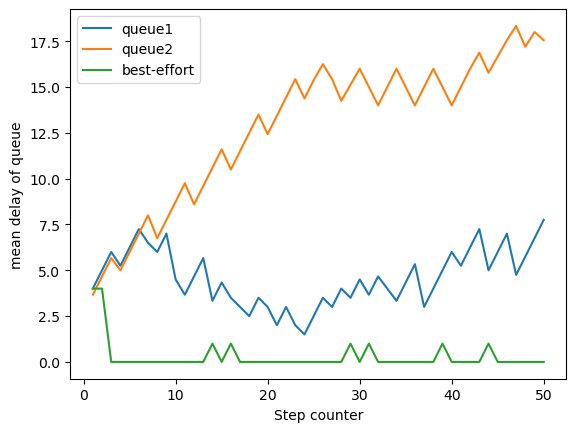

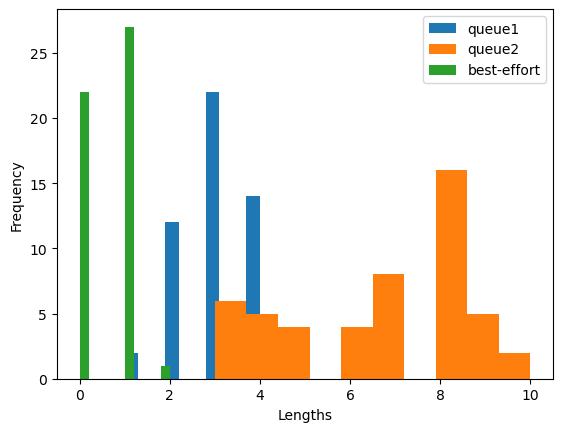

In [125]:
reinforcement_scheduler_plot(env, Q, seed = seed)
reinforcement_scheduler_hist(env, Q, seed = seed)

In [138]:
# generate a "good seed" where performance is above a set parameter
seed = 0
score = 0
GOOD_SCORE = 1

# prevent infinity 
best_score = -20
best_seed = seed

terminate_after = 1000
i = 0

while score < GOOD_SCORE and (i < terminate_after): 
    score = reinforcement_scheduler_no_print(env, Q, seed = seed)
    if best_score < score:
        best_score = score
        best_seed = seed
    seed += 1
    i += 1
seed -= 1
print("Best seed:", best_seed, end = ", ") 
print("best_score =", best_score)



Best seed: 82, best_score = -3


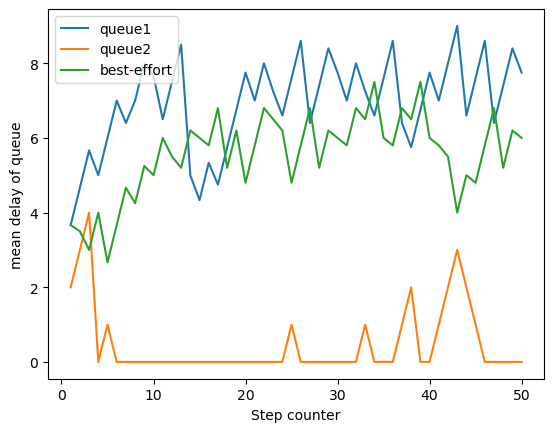

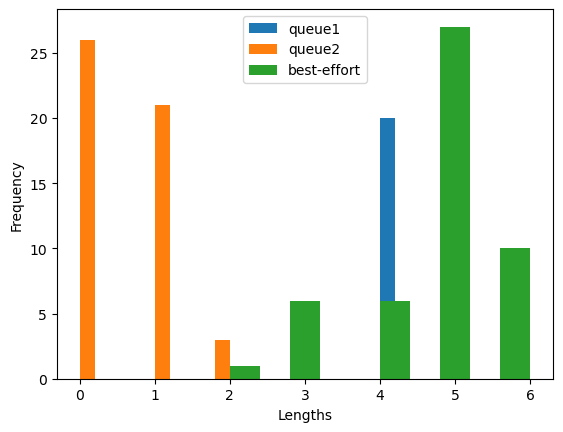

In [139]:
reinforcement_scheduler_plot(env, Q, seed = best_seed)
reinforcement_scheduler_hist(env, Q, seed = best_seed)